## Data Pre-processing

In [1]:
# Import Modules

import math
import data_loader
import numpy as np
import pandas as pd
# import sklearn.preprocessing as preprocessing
# from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# Data Preparation

# Define column names
column_names = [
     'age', 'workclass', 'fnlwgt', 'education', 'education-num', 
     'marital-status', 'occupation', 'relationship', 'race', 'sex', 
     'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary']

# Load and split data by data_loader
train, validation = data_loader.load_train_data('data/adult.data')
test = data_loader.load_test_data('data/adult.test')

# Combined data to consolidate features
train['train'], train['test'] = 1, 0
validation['train'], validation['test'] = 0, 0
test['train'], test['test'] = 0, 1
combined = pd.concat([train, validation, test])
combined.columns = column_names + ['train', 'test']

# Convert label to numerical binary data
combined['salary'] = combined['salary'].replace(' <=50K.', ' <=50K')
combined['salary'] = combined['salary'].replace(' <=50K', 0)
combined['salary'] = combined['salary'].replace(' >50K.', ' >50K')
combined['salary'] = combined['salary'].replace(' >50K', 1)

# Clean garbage
for c in combined.columns:
    combined[c] = combined[c].replace(' ?', np.nan)
combined.dropna(how='any',inplace=True)

print(combined.shape)
combined.sample(n=3)

(45222, 17)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,train,test
27411,43,Private,75993,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,7688,0,40,United-States,1,1,0
26035,44,Private,206878,HS-grad,9,Never-married,Sales,Other-relative,White,Female,0,0,15,United-States,0,1,0
32005,39,Private,128392,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,1887,40,United-States,1,1,0


In [3]:
# Split X
X_combined = pd.concat([combined.iloc[:, :-3], combined.iloc[:, -2:]], axis=1)
print(X_combined.shape)

# Split Y
Y_combined = combined.loc[:,'salary':'test']
print(Y_combined.shape)
Y_train = Y_combined[(Y_combined['train']==1) & (Y_combined['test']==0)].copy()
Y_valid = Y_combined[(Y_combined['train']==0) & (Y_combined['test']==0)].copy()
Y_test  = Y_combined[(Y_combined['train']==0) & (Y_combined['test']==1)].copy()

(45222, 16)
(45222, 3)


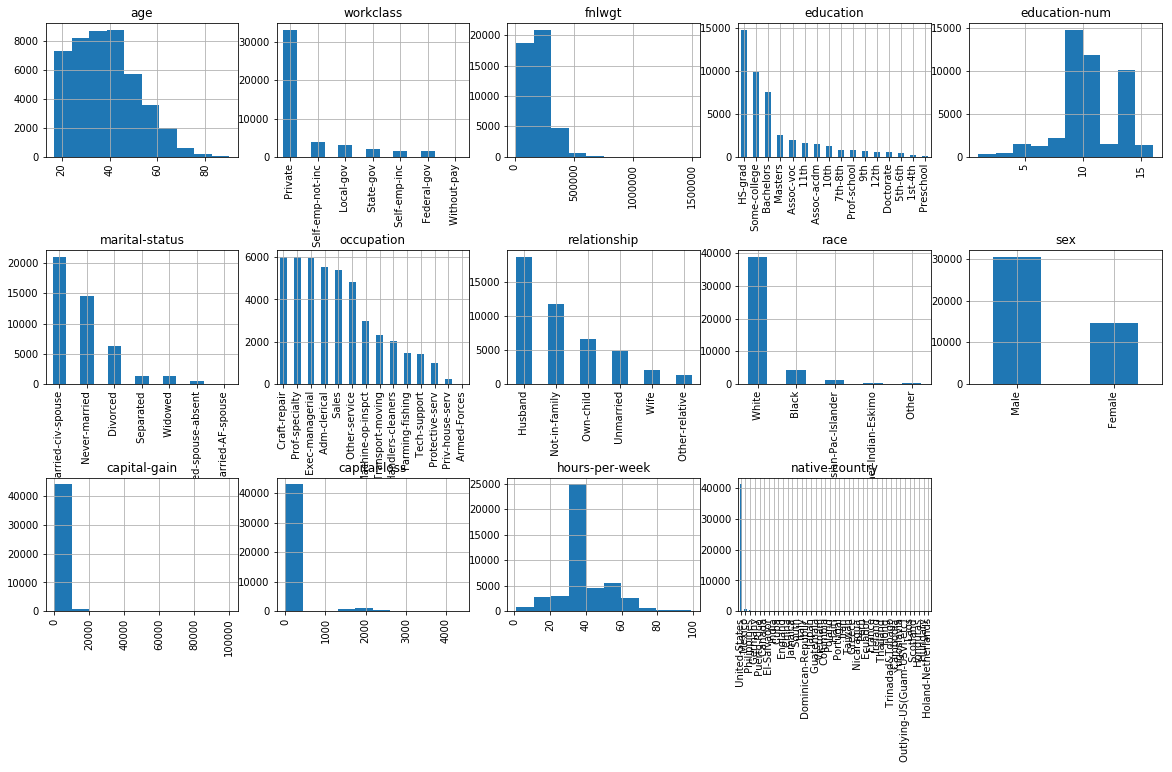

In [4]:
# Plot feature distribution

def plot_feature_distribution(df):
    fig = plt.figure(figsize=(20,15))
    cols = 5
    rows = math.ceil(float(df.shape[1]) / cols)
    for i, column in enumerate(df.columns):
        if column in ['salary', 'train', 'test']: continue
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if df.dtypes[column] == np.object:
            df[column].value_counts().plot(kind="bar", axes=ax)
        else:
            df[column].hist(axes=ax)
            plt.xticks(rotation="vertical")
        plt.grid(True)
    plt.subplots_adjust(hspace=0.7, wspace=0.2)
    plt.show()

# Plot
plot_feature_distribution(X_combined)

In [5]:
# Encoding

def number_encode_features(df):
    result = df.copy()
    for column in result.columns:
        if column in ['train', 'test']: continue
        if result.dtypes[column] == np.object:
            # Fit label encoder and Transform labels to normalized encoding
            result[column] = LabelEncoder().fit_transform(result[column])
    return result

# Numerical Encoding: feature labeling
X_factorized = number_encode_features(X_combined)

# One-hot Ecoding: feature spanning
X_encoded = pd.get_dummies(X_combined)

In [6]:
# Normalizing Data

# First check ranges of each feature
# def summerize_data(df):
#     for column in df.columns:
#         print(column)
#         if df.dtypes[column] == np.object: # Categorical data
#             print(df[column].value_counts())
#         else:
#             print(df[column].describe() )
#         print('\n')
# summerize_data(X_factorized)


# scaler = StandardScaler()

# Normalized factorized data scales
# factorized_norm = pd.DataFrame(
#     scaler.fit_transform(factorized.astype(float)), 
#     columns=factorized.columns
# )
# print(factorized_norm.shape)
# Normalized all data scales
# X_factorized_norm = X_factorized.copy()
# col_names = X_factorized_norm.columns[:-2]
# features = X_factorized_norm[col_names]
# features = scaler.fit_transform(features.values.astype(float))
# X_factorized_norm[col_names] = features


# Normalized encoded data scales
# encoded_norm = pd.DataFrame(
#     scaler.fit_transform(encoded.astype(float)), 
#     columns=encoded.columns
# )
# print(encoded_norm.shape)

In [7]:
# Split data into X and Y with Train, Validation and Test

X_train_n = X_factorized[(X_factorized['train']==1) & (X_factorized['test']==0)].copy()
X_valid_n = X_factorized[(X_factorized['train']==0) & (X_factorized['test']==0)].copy()
X_test_n  = X_factorized[(X_factorized['train']==0) & (X_factorized['test']==1)].copy()
X_train_o = X_encoded[(X_encoded['train']==1) & (X_encoded['test']==0)].copy()
X_valid_o = X_encoded[(X_encoded['train']==0) & (X_encoded['test']==0)].copy()
X_test_o  = X_encoded[(X_encoded['train']==0) & (X_encoded['test']==1)].copy()

X_list = [
    X_train_n, X_valid_n, X_test_n, 
    X_train_o, X_valid_o, X_test_o
]
Y_list = [Y_train, Y_valid, Y_test]
for x in X_list:
    x.drop(["train", "test"], axis=1, inplace=True)
    print(x.shape, end=', ')
print('')
    
for y in Y_list:
    y.drop(["train", "test"], axis=1, inplace=True)
    print(y.shape, end=', ')
print('')

(27175, 14), (2987, 14), (15060, 14), (27175, 104), (2987, 104), (15060, 104), 
(27175, 1), (2987, 1), (15060, 1), 


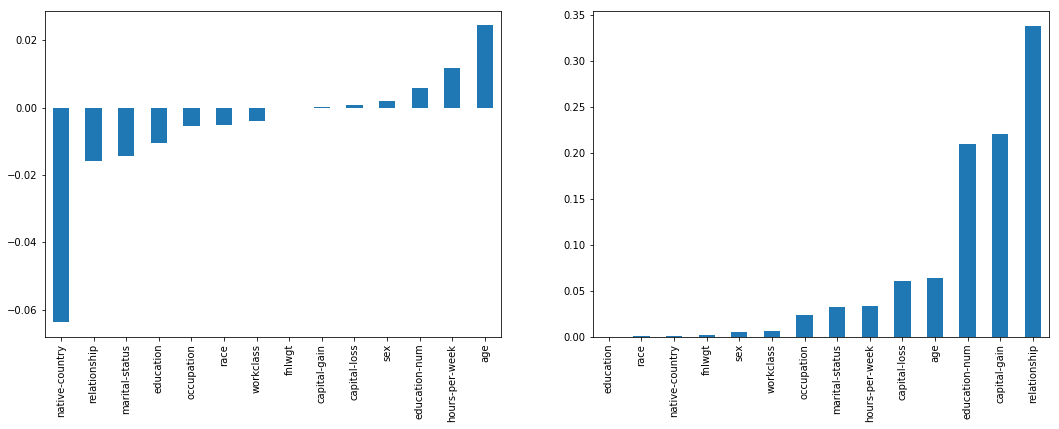

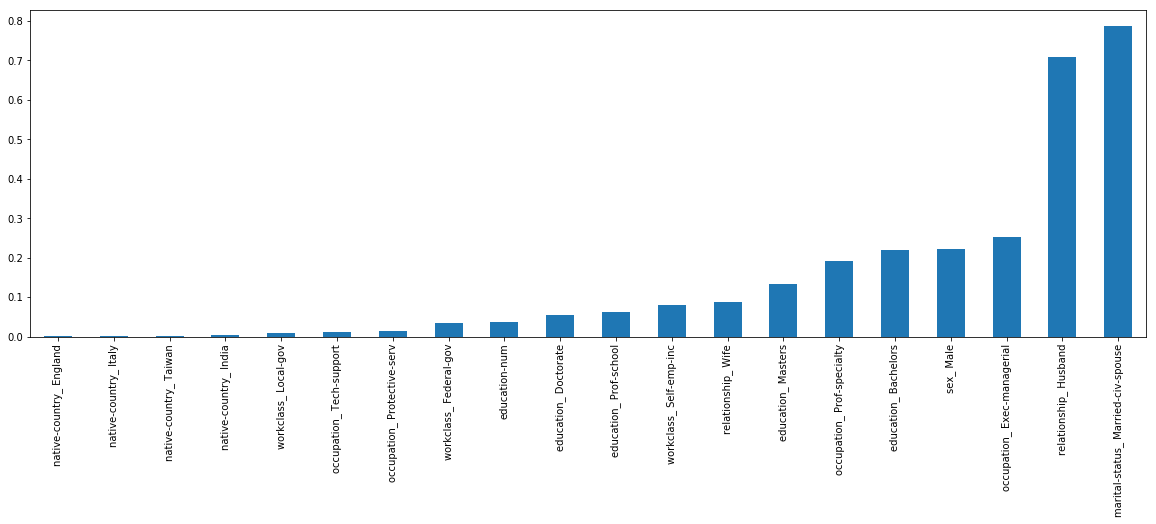

In [8]:
# Plot Corellation and Importance of Data Based on Models

plt.figure(figsize=(18,6))
lr = LogisticRegression(solver='lbfgs', max_iter=300)
lr.fit(X_train_n, Y_train.iloc[:,0])
coefs1 = pd.Series(lr.coef_[0], index=X_train_n.columns)
plt.subplot(1,2,1)
coefs1.sort_values().plot(kind="bar")
# plt.show()

gb = GradientBoostingClassifier()
gb.fit(X_train_n, Y_train.iloc[:,0])
importance = gb.feature_importances_
coefs2 = pd.Series(importance, index=X_train_n.columns)
plt.subplot(1,2,2)
coefs2.sort_values().plot(kind="bar")
plt.show()

# Plot using data encoded with one-hot
lr = LogisticRegression(solver='lbfgs', max_iter=300)
lr.fit(X_train_o, Y_train.iloc[:,0])
plt.figure(figsize=(20,6))
coefs1 = pd.Series(lr.coef_[0], index=X_train_o.columns)
coefs1.sort_values()[-20:].plot(kind="bar")
plt.show()